# Regresja

In [1]:
import warnings
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics, model_selection
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures

Rozważmy zbiór Boston

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
boston = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

In [3]:
# get the data

boston_X = np.hstack([boston.values[::2, :], boston.values[1::2, :2]])
boston_Y = boston.values[1::2, 2]

Podzielmy zbiór na część testową i treningową .

In [4]:
# Split the data into training/testing sets
boston_X_train = boston_X[:-50]
boston_X_test = boston_X[-50:]

# Split the targets into training/testing sets
boston_y_train = boston_Y[:-50]
boston_y_test = boston_Y[-50:]

In [5]:
X = boston_X_train
y = boston_y_train

# Zadanie
Znajdż najleprzy model dzieląc na zbiór testowy i terningowy.


In [6]:
seed = 123
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)

In [7]:
grid_1 = GridSearchCV(
    make_pipeline(PolynomialFeatures(), ElasticNet(random_state=seed)),
    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                'elasticnet__alpha': [0.01, 0.1, 1, 10]},
    cv=kfold,
    refit=True
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_1.fit(X, y)

deg, alpha = grid_1.best_params_['polynomialfeatures__degree'], grid_1.best_params_['elasticnet__alpha']

print(f"Best parameters: degree={deg}, alpha={alpha}")

Best parameters: degree=2, alpha=0.1


In [8]:
grid_1.cv_results_['mean_test_score'].reshape(4, -1)

array([[0.70805942, 0.81680208, 0.74702819, 0.63462343],
       [0.70014515, 0.83003047, 0.73343859, 0.63043122],
       [0.66429641, 0.82359064, 0.75795199, 0.61636726],
       [0.52367919, 0.80580758, 0.7581234 , 0.61997622]])

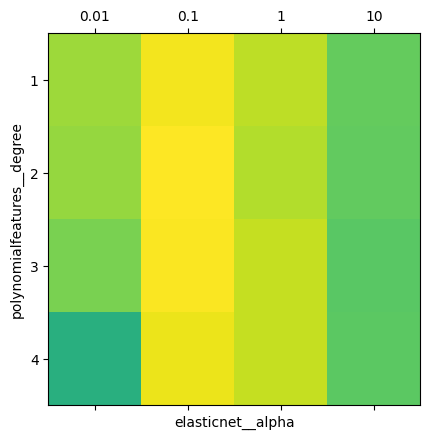

In [9]:
plt.matshow(grid_1.cv_results_['mean_test_score'].reshape(4, -1),
            vmin=0, cmap="viridis")

plt.xticks(np.arange(4), [0.01, 0.1, 1, 10])
plt.yticks(np.arange(4), [1, 2, 3, 4])
plt.xlabel("elasticnet__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.show()

In [10]:
from sklearn import metrics

X_test = boston_X_test
y_test = boston_y_test

reg_models = {
    'lr': LinearRegression(),
    'elasticnet': ElasticNet(),
    'lasso': Lasso(),
    'ridge': Ridge()
}


def best_fit(reg_model: Literal['elasticnet', 'lasso', 'ridge', 'lr']) -> Pipeline:
    param_grid = {
        'polynomialfeatures__degree': [1, 2, 3, 4],
    }
    if reg_model != 'lr':
        param_grid[f'{reg_model}__alpha'] = [0.01, 0.1, 1, 10]

    grid = GridSearchCV(
        make_pipeline(PolynomialFeatures(), reg_models[reg_model]),
        param_grid=param_grid,
        cv=kfold,
        scoring="neg_mean_squared_error"
    )
    grid.fit(X, y)
    best_degree = grid.best_params_['polynomialfeatures__degree']
    best_alpha = grid.best_params_.get(f'{reg_model}__alpha', 'not applicable') 
    return grid.best_estimator_, best_alpha, best_degree

def get_measures(model: Pipeline) -> tuple[float, float, float, float, float]:
    y_pred = model.predict(X_test)
    return (
        metrics.r2_score(y_test, y_pred),
        metrics.explained_variance_score(y_test, y_pred),
        metrics.median_absolute_error(y_test, y_pred),
        metrics.mean_squared_error(y_test, y_pred),
        metrics.mean_absolute_error(y_test, y_pred)
    )

In [11]:
df = pd.DataFrame(
    columns=[
        'Method', 'Degree', 'Alpha', 'R2', 'Explained variance', 'Median absolute error', 'Mean squared error', 'Mean absolute error'
    ]
)

for i, reg in enumerate(reg_models.keys()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model, alpha, deg = best_fit(reg.lower())
    r2, evs, mae, mse, mae = get_measures(model)
    df.loc[i] = [reg, deg, alpha, r2, evs, mae, mse, mae]

df.head()

,Method,Degree,Alpha,R2,Explained variance,Median absolute error,Mean squared error,Mean absolute error
0,lr,2,not applicable,-3.841594,-2.783637,6.162484,91.326502,6.162484
1,elasticnet,2,0.1,-1.289418,-1.271541,4.829785,43.185069,4.829785
2,lasso,2,0.1,-1.340562,-1.333650,4.883117,44.149789,4.883117
3,ridge,2,0.01,-2.084505,-1.856149,4.910185,58.182701,4.910185


In [12]:
print("Best model:")
df.loc[df['R2'].idxmax()]

Best model:


Method                   elasticnet
Degree                            2
Alpha                           0.1
R2                        -1.289418
Explained variance        -1.271541
Median absolute error      4.829785
Mean squared error        43.185069
Mean absolute error        4.829785
Name: 1, dtype: object